# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

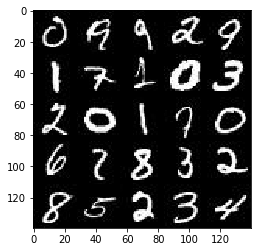

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

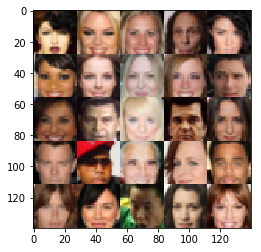

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.65
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm2 = tf.layers.batch_normalization(layer2, training=True)
        dropout2 = tf.layers.dropout(batch_norm2, rate=keep_prob, training=True)
        relu2 = tf.maximum(alpha*dropout2, dropout2)
        
        layer3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        batch_norm3 = tf.layers.batch_normalization(layer3, training=True)
        dropout3 = tf.layers.dropout(batch_norm3, rate=keep_prob, training=True)
        relu3 = tf.maximum(alpha*dropout3, dropout3)
        
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    reuse = not is_train
    keep_prob = 0.65
    alpha = 0.2
    
    with(tf.variable_scope('generator', reuse=reuse)):
        
        layer1 = tf.layers.dense(z, 4*4*512)
        layer1 = tf.reshape(layer1, (-1, 4, 4, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.layers.dropout(layer1, rate=keep_prob, training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.layers.dropout(layer2, rate=keep_prob, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.layers.dropout(layer3, rate=keep_prob, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28,28))
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*1-(smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()

    def get_vars_prefixed(variables, prefix):
        new_vars = []
        for variable in variables:
            if(variable.name[0:len(prefix)] == prefix):
                new_vars.append(variable)
        return new_vars

    g_vars = get_vars_prefixed(t_vars, 'generator')
    d_vars = get_vars_prefixed(t_vars, 'discriminator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver(var_list = g_vars)

    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=50
    show_every=100
    
    if(data_image_mode == 'RGB'):
        input_channels = 3
    else:
        input_channels = 1
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], input_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, input_channels)
        
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Rescale images to be between -1 to 1
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                

                # Run optimizers
    
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, input_channels, data_image_mode)

    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 50... Discriminator Loss: 1.8282... Generator Loss: 1.2251
Epoch 1/2... Step 100... Discriminator Loss: 2.4873... Generator Loss: 1.0511


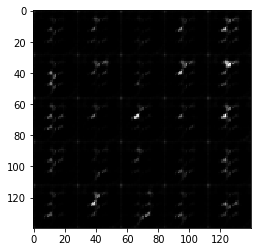

Epoch 1/2... Step 150... Discriminator Loss: 1.6809... Generator Loss: 1.2753
Epoch 1/2... Step 200... Discriminator Loss: 1.5375... Generator Loss: 1.4877


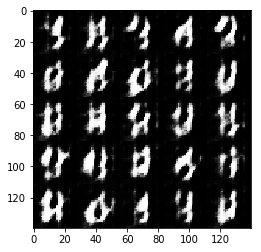

Epoch 1/2... Step 250... Discriminator Loss: 1.4901... Generator Loss: 0.9717
Epoch 1/2... Step 300... Discriminator Loss: 1.4833... Generator Loss: 1.5398


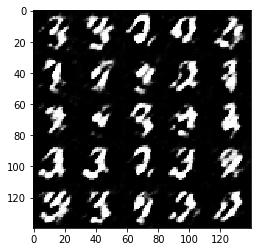

Epoch 1/2... Step 350... Discriminator Loss: 1.3123... Generator Loss: 1.4534
Epoch 1/2... Step 400... Discriminator Loss: 1.5734... Generator Loss: 1.1771


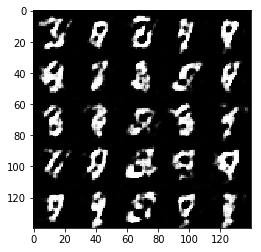

Epoch 1/2... Step 450... Discriminator Loss: 1.5061... Generator Loss: 1.4108
Epoch 1/2... Step 500... Discriminator Loss: 1.1925... Generator Loss: 1.1006


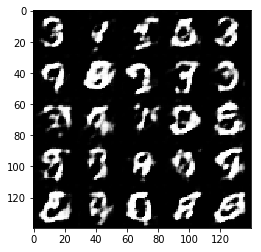

Epoch 1/2... Step 550... Discriminator Loss: 1.2619... Generator Loss: 1.6337
Epoch 1/2... Step 600... Discriminator Loss: 1.1798... Generator Loss: 1.2254


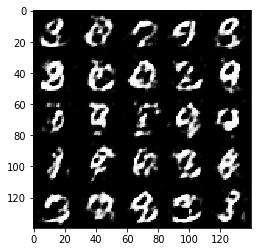

Epoch 1/2... Step 650... Discriminator Loss: 1.2599... Generator Loss: 0.8702
Epoch 1/2... Step 700... Discriminator Loss: 1.1282... Generator Loss: 1.3502


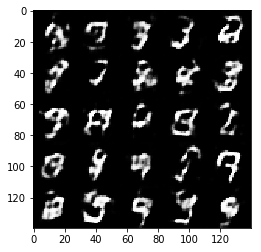

Epoch 1/2... Step 750... Discriminator Loss: 1.4704... Generator Loss: 0.6857
Epoch 1/2... Step 800... Discriminator Loss: 1.0792... Generator Loss: 1.5262


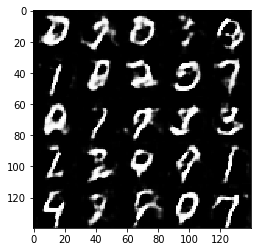

Epoch 1/2... Step 850... Discriminator Loss: 1.0751... Generator Loss: 1.6939
Epoch 1/2... Step 900... Discriminator Loss: 1.2938... Generator Loss: 1.1489


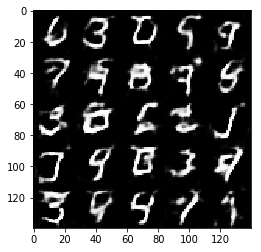

Epoch 1/2... Step 950... Discriminator Loss: 1.3192... Generator Loss: 1.0363
Epoch 1/2... Step 1000... Discriminator Loss: 1.3227... Generator Loss: 1.3571


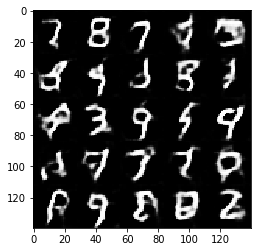

Epoch 1/2... Step 1050... Discriminator Loss: 1.1617... Generator Loss: 1.0980
Epoch 1/2... Step 1100... Discriminator Loss: 1.1347... Generator Loss: 1.1866


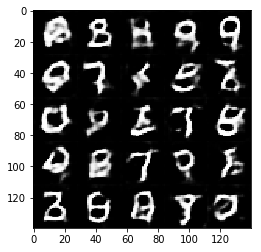

Epoch 1/2... Step 1150... Discriminator Loss: 1.4484... Generator Loss: 1.1676
Epoch 1/2... Step 1200... Discriminator Loss: 1.1324... Generator Loss: 1.2780


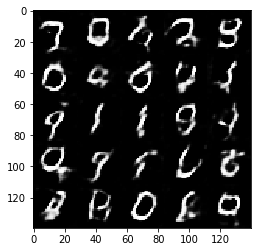

Epoch 1/2... Step 1250... Discriminator Loss: 1.3407... Generator Loss: 0.8419
Epoch 1/2... Step 1300... Discriminator Loss: 1.3607... Generator Loss: 1.3089


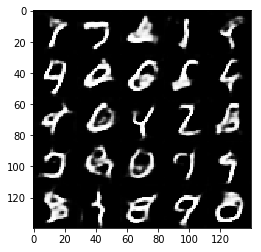

Epoch 1/2... Step 1350... Discriminator Loss: 1.3388... Generator Loss: 1.3068
Epoch 1/2... Step 1400... Discriminator Loss: 1.3638... Generator Loss: 1.0023


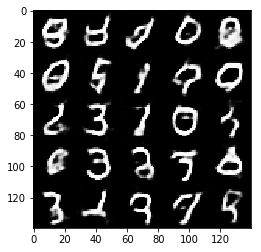

Epoch 1/2... Step 1450... Discriminator Loss: 1.2776... Generator Loss: 0.9078
Epoch 1/2... Step 1500... Discriminator Loss: 1.1351... Generator Loss: 0.9976


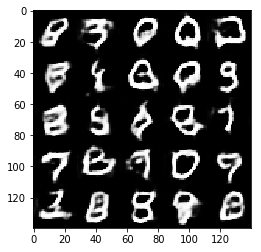

Epoch 1/2... Step 1550... Discriminator Loss: 1.0823... Generator Loss: 1.1912


KeyboardInterrupt: 

In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 50... Discriminator Loss: 0.8475... Generator Loss: 2.9632
Epoch 1/1... Step 100... Discriminator Loss: 1.0982... Generator Loss: 1.9966


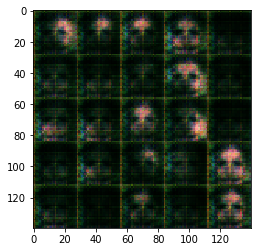

Epoch 1/1... Step 150... Discriminator Loss: 1.4719... Generator Loss: 1.6327
Epoch 1/1... Step 200... Discriminator Loss: 1.2837... Generator Loss: 1.3636


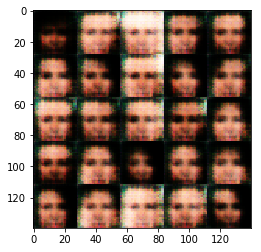

Epoch 1/1... Step 250... Discriminator Loss: 1.3230... Generator Loss: 2.4622
Epoch 1/1... Step 300... Discriminator Loss: 1.3839... Generator Loss: 1.2473


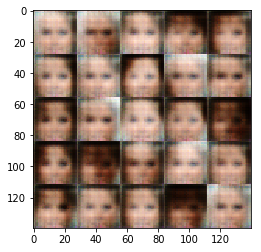

Epoch 1/1... Step 350... Discriminator Loss: 1.1003... Generator Loss: 1.3228
Epoch 1/1... Step 400... Discriminator Loss: 1.6268... Generator Loss: 1.5457


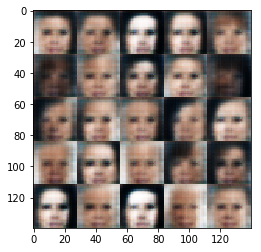

Epoch 1/1... Step 450... Discriminator Loss: 1.0149... Generator Loss: 1.6062
Epoch 1/1... Step 500... Discriminator Loss: 1.3598... Generator Loss: 1.2154


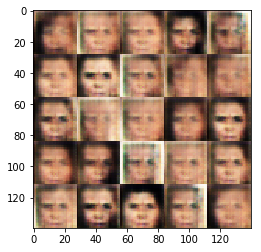

Epoch 1/1... Step 550... Discriminator Loss: 1.4280... Generator Loss: 1.2493
Epoch 1/1... Step 600... Discriminator Loss: 1.2841... Generator Loss: 1.3474


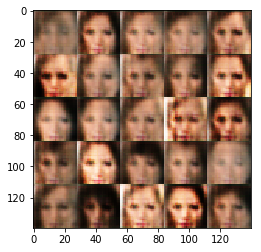

Epoch 1/1... Step 650... Discriminator Loss: 1.3155... Generator Loss: 1.0063
Epoch 1/1... Step 700... Discriminator Loss: 1.6608... Generator Loss: 0.8304


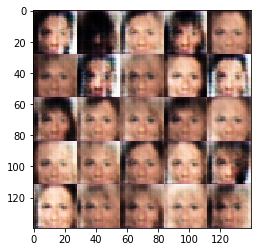

Epoch 1/1... Step 750... Discriminator Loss: 1.2238... Generator Loss: 1.4358
Epoch 1/1... Step 800... Discriminator Loss: 1.5414... Generator Loss: 0.9346


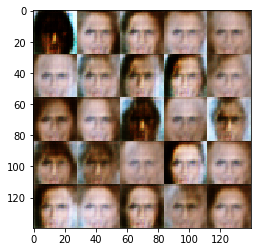

Epoch 1/1... Step 850... Discriminator Loss: 1.3049... Generator Loss: 0.9112
Epoch 1/1... Step 900... Discriminator Loss: 1.3908... Generator Loss: 1.1922


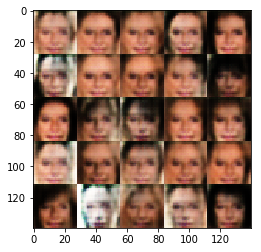

Epoch 1/1... Step 950... Discriminator Loss: 1.1575... Generator Loss: 1.0563
Epoch 1/1... Step 1000... Discriminator Loss: 1.4122... Generator Loss: 1.3621


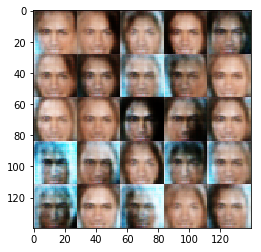

Epoch 1/1... Step 1050... Discriminator Loss: 1.3961... Generator Loss: 0.8063
Epoch 1/1... Step 1100... Discriminator Loss: 1.2009... Generator Loss: 1.0434


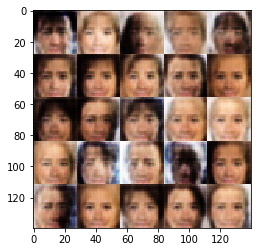

Epoch 1/1... Step 1150... Discriminator Loss: 1.9308... Generator Loss: 0.9130
Epoch 1/1... Step 1200... Discriminator Loss: 1.3569... Generator Loss: 1.0648


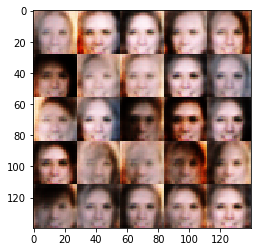

Epoch 1/1... Step 1250... Discriminator Loss: 1.3471... Generator Loss: 0.9034
Epoch 1/1... Step 1300... Discriminator Loss: 1.2284... Generator Loss: 0.9772


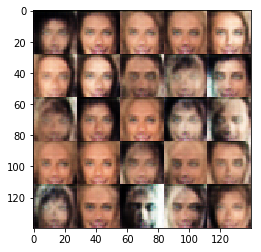

Epoch 1/1... Step 1350... Discriminator Loss: 1.2029... Generator Loss: 1.2595
Epoch 1/1... Step 1400... Discriminator Loss: 1.3267... Generator Loss: 1.0144


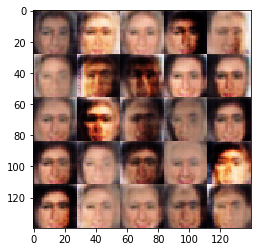

Epoch 1/1... Step 1450... Discriminator Loss: 1.0974... Generator Loss: 0.9792
Epoch 1/1... Step 1500... Discriminator Loss: 1.5243... Generator Loss: 1.0908


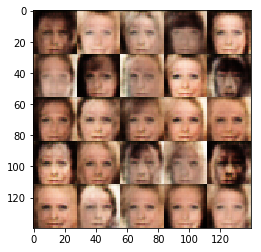

Epoch 1/1... Step 1550... Discriminator Loss: 1.3530... Generator Loss: 1.1178
Epoch 1/1... Step 1600... Discriminator Loss: 1.3355... Generator Loss: 1.1174


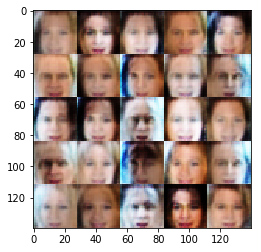

Epoch 1/1... Step 1650... Discriminator Loss: 1.5273... Generator Loss: 0.6782
Epoch 1/1... Step 1700... Discriminator Loss: 1.3061... Generator Loss: 1.0418


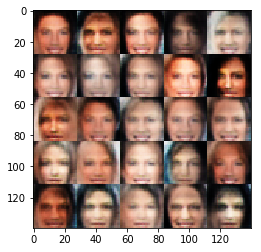

Epoch 1/1... Step 1750... Discriminator Loss: 1.3803... Generator Loss: 0.8667
Epoch 1/1... Step 1800... Discriminator Loss: 1.6506... Generator Loss: 0.9101


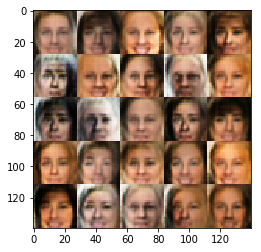

Epoch 1/1... Step 1850... Discriminator Loss: 1.2211... Generator Loss: 0.9845
Epoch 1/1... Step 1900... Discriminator Loss: 1.3713... Generator Loss: 0.9151


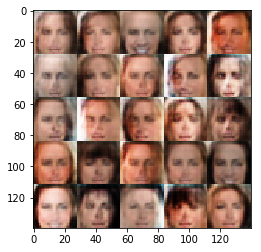

Epoch 1/1... Step 1950... Discriminator Loss: 1.4283... Generator Loss: 0.8730
Epoch 1/1... Step 2000... Discriminator Loss: 1.3279... Generator Loss: 1.0140


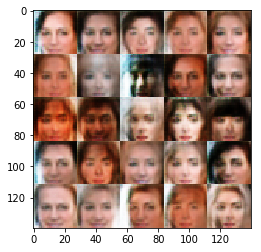

Epoch 1/1... Step 2050... Discriminator Loss: 1.6323... Generator Loss: 0.9305
Epoch 1/1... Step 2100... Discriminator Loss: 1.3554... Generator Loss: 0.9788


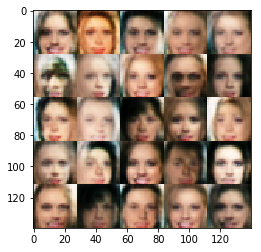

Epoch 1/1... Step 2150... Discriminator Loss: 1.3216... Generator Loss: 0.8637
Epoch 1/1... Step 2200... Discriminator Loss: 1.3028... Generator Loss: 0.9515


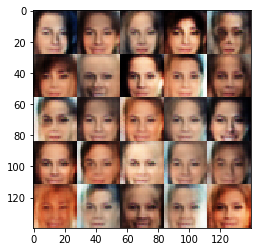

Epoch 1/1... Step 2250... Discriminator Loss: 1.3468... Generator Loss: 0.7263
Epoch 1/1... Step 2300... Discriminator Loss: 1.3708... Generator Loss: 0.7765


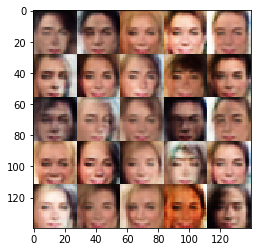

Epoch 1/1... Step 2350... Discriminator Loss: 1.5366... Generator Loss: 0.7052
Epoch 1/1... Step 2400... Discriminator Loss: 1.2650... Generator Loss: 1.0264


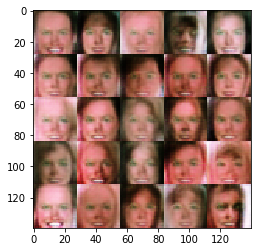

Epoch 1/1... Step 2450... Discriminator Loss: 1.3572... Generator Loss: 0.7833
Epoch 1/1... Step 2500... Discriminator Loss: 1.2955... Generator Loss: 0.8743


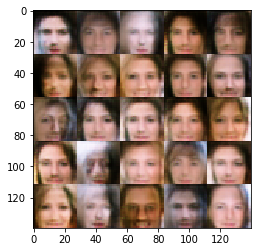

Epoch 1/1... Step 2550... Discriminator Loss: 1.3596... Generator Loss: 0.8952
Epoch 1/1... Step 2600... Discriminator Loss: 1.2376... Generator Loss: 0.8966


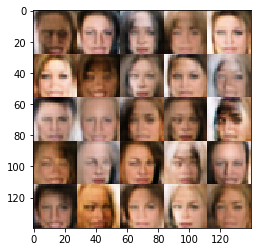

Epoch 1/1... Step 2650... Discriminator Loss: 1.2990... Generator Loss: 0.8349
Epoch 1/1... Step 2700... Discriminator Loss: 1.2933... Generator Loss: 0.8370


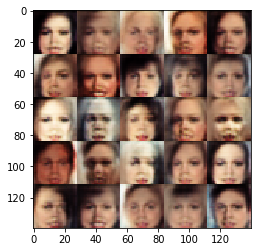

Epoch 1/1... Step 2750... Discriminator Loss: 1.3597... Generator Loss: 1.0026
Epoch 1/1... Step 2800... Discriminator Loss: 1.2377... Generator Loss: 0.8679


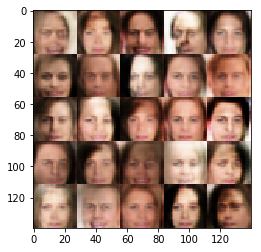

Epoch 1/1... Step 2850... Discriminator Loss: 1.1738... Generator Loss: 0.9711
Epoch 1/1... Step 2900... Discriminator Loss: 1.3163... Generator Loss: 0.9264


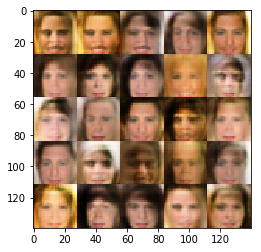

Epoch 1/1... Step 2950... Discriminator Loss: 1.3311... Generator Loss: 0.9364
Epoch 1/1... Step 3000... Discriminator Loss: 1.4124... Generator Loss: 0.8007


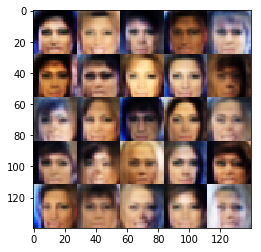

Epoch 1/1... Step 3050... Discriminator Loss: 1.3201... Generator Loss: 0.9253
Epoch 1/1... Step 3100... Discriminator Loss: 1.4026... Generator Loss: 0.8761


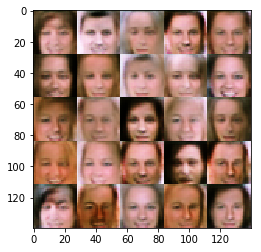

Epoch 1/1... Step 3150... Discriminator Loss: 1.4164... Generator Loss: 1.0072
Epoch 1/1... Step 3200... Discriminator Loss: 1.3909... Generator Loss: 0.8632


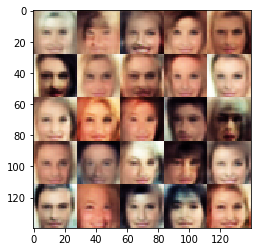

Epoch 1/1... Step 3250... Discriminator Loss: 1.3141... Generator Loss: 0.7583
Epoch 1/1... Step 3300... Discriminator Loss: 1.4952... Generator Loss: 0.8757


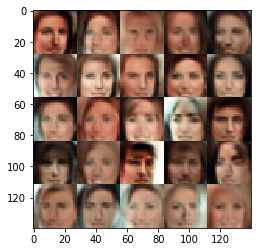

Epoch 1/1... Step 3350... Discriminator Loss: 1.4066... Generator Loss: 0.7940
Epoch 1/1... Step 3400... Discriminator Loss: 1.2585... Generator Loss: 0.9580


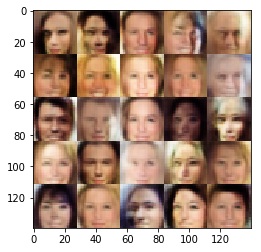

Epoch 1/1... Step 3450... Discriminator Loss: 1.4162... Generator Loss: 0.8701
Epoch 1/1... Step 3500... Discriminator Loss: 1.3764... Generator Loss: 0.7496


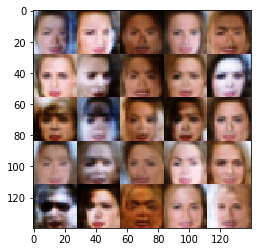

Epoch 1/1... Step 3550... Discriminator Loss: 1.3056... Generator Loss: 0.8955
Epoch 1/1... Step 3600... Discriminator Loss: 1.3858... Generator Loss: 0.7510


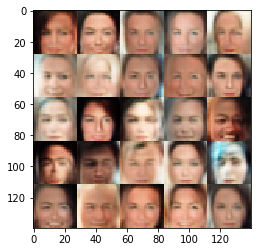

Epoch 1/1... Step 3650... Discriminator Loss: 1.3760... Generator Loss: 0.8585
Epoch 1/1... Step 3700... Discriminator Loss: 1.4124... Generator Loss: 0.8713


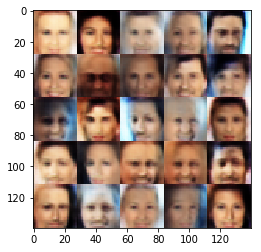

Epoch 1/1... Step 3750... Discriminator Loss: 1.2635... Generator Loss: 0.9180
Epoch 1/1... Step 3800... Discriminator Loss: 1.3723... Generator Loss: 1.0217


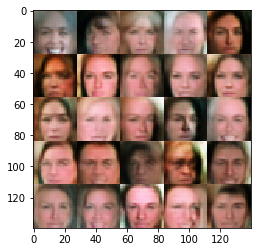

Epoch 1/1... Step 3850... Discriminator Loss: 1.3048... Generator Loss: 0.8933
Epoch 1/1... Step 3900... Discriminator Loss: 1.3545... Generator Loss: 0.8896


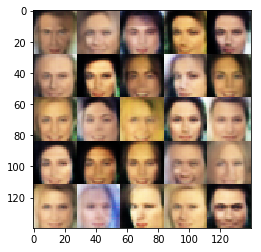

Epoch 1/1... Step 3950... Discriminator Loss: 1.3436... Generator Loss: 1.0091
Epoch 1/1... Step 4000... Discriminator Loss: 1.3710... Generator Loss: 0.9590


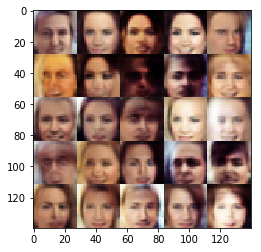

Epoch 1/1... Step 4050... Discriminator Loss: 1.3311... Generator Loss: 0.8605
Epoch 1/1... Step 4100... Discriminator Loss: 1.3237... Generator Loss: 1.1712


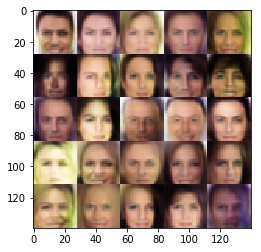

Epoch 1/1... Step 4150... Discriminator Loss: 1.3947... Generator Loss: 0.8495
Epoch 1/1... Step 4200... Discriminator Loss: 1.3488... Generator Loss: 0.8711


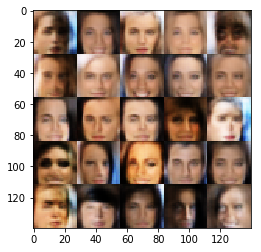

Epoch 1/1... Step 4250... Discriminator Loss: 1.3258... Generator Loss: 0.9474
Epoch 1/1... Step 4300... Discriminator Loss: 1.3165... Generator Loss: 1.0352


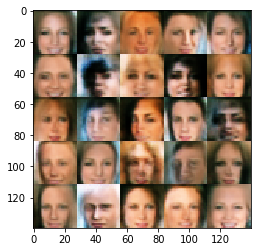

Epoch 1/1... Step 4350... Discriminator Loss: 1.2610... Generator Loss: 0.8756
Epoch 1/1... Step 4400... Discriminator Loss: 1.2561... Generator Loss: 1.0325


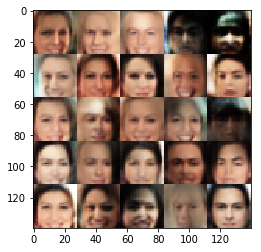

Epoch 1/1... Step 4450... Discriminator Loss: 1.2569... Generator Loss: 0.8383
Epoch 1/1... Step 4500... Discriminator Loss: 1.3468... Generator Loss: 0.9941


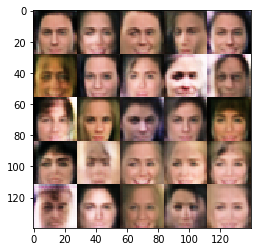

Epoch 1/1... Step 4550... Discriminator Loss: 1.3414... Generator Loss: 0.8772
Epoch 1/1... Step 4600... Discriminator Loss: 1.3331... Generator Loss: 0.7905


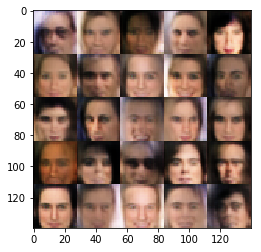

Epoch 1/1... Step 4650... Discriminator Loss: 1.2168... Generator Loss: 1.1202
Epoch 1/1... Step 4700... Discriminator Loss: 1.2331... Generator Loss: 0.9858


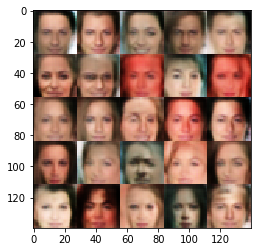

Epoch 1/1... Step 4750... Discriminator Loss: 1.3496... Generator Loss: 1.0218
Epoch 1/1... Step 4800... Discriminator Loss: 1.4122... Generator Loss: 0.9269


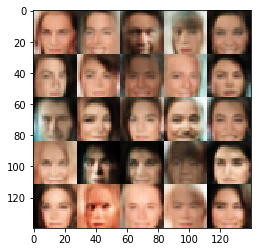

Epoch 1/1... Step 4850... Discriminator Loss: 1.3513... Generator Loss: 0.9914
Epoch 1/1... Step 4900... Discriminator Loss: 1.2278... Generator Loss: 0.9179


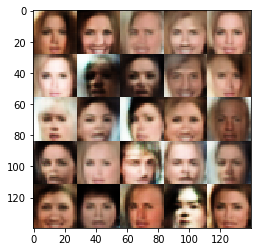

Epoch 1/1... Step 4950... Discriminator Loss: 1.3646... Generator Loss: 1.0337
Epoch 1/1... Step 5000... Discriminator Loss: 1.3392... Generator Loss: 0.9168


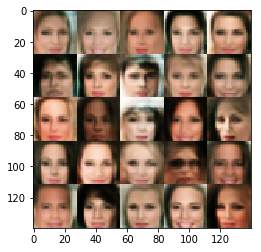

Epoch 1/1... Step 5050... Discriminator Loss: 1.3528... Generator Loss: 0.9040
Epoch 1/1... Step 5100... Discriminator Loss: 1.2254... Generator Loss: 0.9576


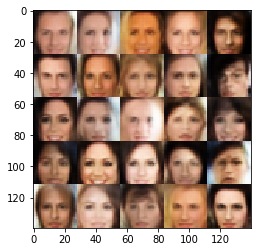

Epoch 1/1... Step 5150... Discriminator Loss: 1.2376... Generator Loss: 0.9583
Epoch 1/1... Step 5200... Discriminator Loss: 1.2508... Generator Loss: 1.2150


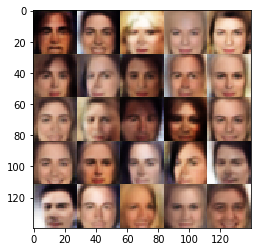

Epoch 1/1... Step 5250... Discriminator Loss: 1.3367... Generator Loss: 0.9676
Epoch 1/1... Step 5300... Discriminator Loss: 1.3943... Generator Loss: 0.9038


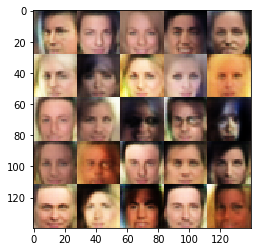

Epoch 1/1... Step 5350... Discriminator Loss: 1.3077... Generator Loss: 0.9669
Epoch 1/1... Step 5400... Discriminator Loss: 1.2569... Generator Loss: 0.8066


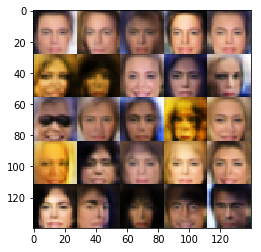

Epoch 1/1... Step 5450... Discriminator Loss: 1.3401... Generator Loss: 0.9411
Epoch 1/1... Step 5500... Discriminator Loss: 1.3980... Generator Loss: 0.9459


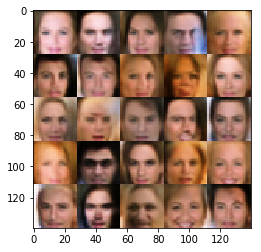

Epoch 1/1... Step 5550... Discriminator Loss: 1.2262... Generator Loss: 0.9862
Epoch 1/1... Step 5600... Discriminator Loss: 1.2209... Generator Loss: 0.8422


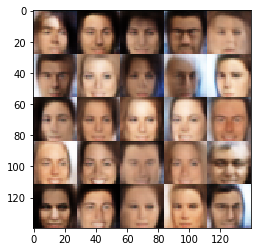

Epoch 1/1... Step 5650... Discriminator Loss: 1.1874... Generator Loss: 0.9382
Epoch 1/1... Step 5700... Discriminator Loss: 1.2855... Generator Loss: 0.9412


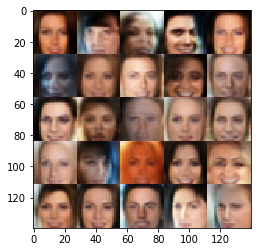

Epoch 1/1... Step 5750... Discriminator Loss: 1.3397... Generator Loss: 0.9401
Epoch 1/1... Step 5800... Discriminator Loss: 1.2517... Generator Loss: 0.9643


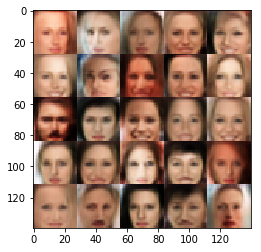

Epoch 1/1... Step 5850... Discriminator Loss: 1.2920... Generator Loss: 1.0263
Epoch 1/1... Step 5900... Discriminator Loss: 1.3545... Generator Loss: 0.7948


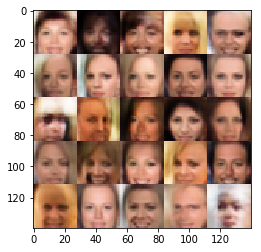

Epoch 1/1... Step 5950... Discriminator Loss: 1.3184... Generator Loss: 0.9452
Epoch 1/1... Step 6000... Discriminator Loss: 1.2572... Generator Loss: 0.9930


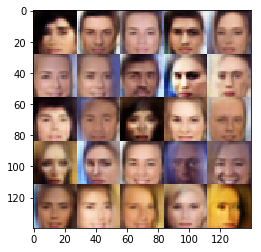

Epoch 1/1... Step 6050... Discriminator Loss: 1.1625... Generator Loss: 0.9684
Epoch 1/1... Step 6100... Discriminator Loss: 1.3260... Generator Loss: 1.0988


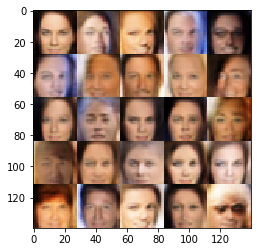

Epoch 1/1... Step 6150... Discriminator Loss: 1.2659... Generator Loss: 1.0758
Epoch 1/1... Step 6200... Discriminator Loss: 1.1877... Generator Loss: 0.9615


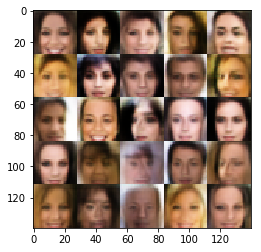

Epoch 1/1... Step 6250... Discriminator Loss: 1.2511... Generator Loss: 1.0942
Epoch 1/1... Step 6300... Discriminator Loss: 1.2445... Generator Loss: 1.0722


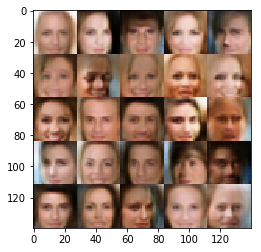

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.